In [1]:
import numpy as np
import cv2
from image_geometry import PinholeCameraModel
from sensor_msgs.msg import CameraInfo
from duckietown_utils.yaml_wrap import yaml_load_file

/usr/local/lib/python2.7/dist-packages/geometry/__init__.py:18: UserWarning: Scipy not found -- needed for functions logm, expm, eigh. I will go on without it, but later an error will be thrown if those functions are used.
  warnings.warn(msg)


In [2]:
# Prepare visualisation tools
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

def bgrshow(bgr):
    imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    
def imshow(img):
    plt.figure(figsize=(9,8), dpi= 80, facecolor='w', edgecolor='k')
    #plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()

In [3]:
# Load jpegs
import glob
raw = []
for im_path in sorted(glob.glob("frames/*.png")):
    bgr = cv2.imread(im_path,cv2.IMREAD_COLOR)
    raw.append(bgr)

In [4]:
# Prepare the AI filter
from AntiInstagram import AntiInstagram
ai = AntiInstagram()

output_scale = 1
color_balance_percentage = 0.8

try:
    raw0 = raw[0]
except (NameError, IndexError) as e:    
    print("No image in raw[0] to calibrate AI filter")
else:
    ai.calculate_color_balance_thresholds(raw0, output_scale, color_balance_percentage)

In [5]:
H = np.array([-3.589767590401803e-05, -0.00023491693147080584, -0.1374201532070648,
               0.0008247535901185687, -5.00225097638814e-06,   -0.2685590146427659, 
              -5.664504414708967e-05, -0.006300114132830898,    1.0])
H = np.reshape(H,(3,3))

In [6]:
def camera_info_from_yaml(filename):
    calib_data = yaml_load_file(filename)
    cam_info = CameraInfo()
    cam_info.width = calib_data['image_width']
    cam_info.height = calib_data['image_height']
    cam_info.K = calib_data['camera_matrix']['data']
    cam_info.D = calib_data['distortion_coefficients']['data']
    cam_info.R = calib_data['rectification_matrix']['data']
    cam_info.P = calib_data['projection_matrix']['data']
    cam_info.distortion_model = calib_data['distortion_model']
    return cam_info

def make_undistort_maps(ci):
    K = np.array(ci.K).reshape((3,3))
    D = np.array(ci.D).reshape((1,5))
    R = np.array(ci.R).reshape((3,3))
    P = np.array(ci.P).reshape((3,4))
    mapx = np.ndarray(shape=(ci.height, ci.width, 1), dtype='float32')
    mapy = np.ndarray(shape=(ci.height, ci.width, 1), dtype='float32')
    mapx, mapy = cv2.initUndistortRectifyMap(K, D, R, P, 
                     (ci.width, ci.height), cv2.CV_32FC1, mapx, mapy)
    return mapx, mapy


In [7]:
ci = camera_info_from_yaml('old_intrinsics.yaml')
mapx, mapy = make_undistort_maps(ci)
pcm = PinholeCameraModel()
pcm.fromCameraInfo(ci)

In [8]:
hsv_red1 = np.array([  0,140,100])
hsv_red2 = np.array([ 15,255,255])
hsv_red3 = np.array([165,140,100])
hsv_red4 = np.array([180,255,255])
cutoff   = 0
# input is full res raw bitmaps
# output is full res rectified, cropped, stop lines


def preprocess(img, **kwargs):
    rectarg = kwargs.get('rectify')
    if rectarg is None:
        rectarg = True
    if rectarg:
        rect = rectify(img)  # rectify
    else:
        rect = img
    crpd = rect[cutoff:]  # crop
    aied = ai.apply_color_balance(crpd, output_scale)  # color balance
    hsv = cv2.cvtColor(aied, cv2.COLOR_BGR2HSV)       
    bw1 = cv2.inRange(hsv, hsv_red1, hsv_red2)
    bw2 = cv2.inRange(hsv, hsv_red3, hsv_red4)
    red = cv2.bitwise_or(bw1, bw2)  # select red       
    return red

In [9]:
def myFun(**kwargs):  
    hey = kwargs.get('ciao')
    if hey is None:
        hey = "hello"
    print (hey) 
myFun()

hello


In [35]:
# Rectifies image using pinhole camera model
def rectify(cv_image_raw):
    cv_image_rectified = np.zeros(np.shape(cv_image_raw))
    return cv2.remap(cv_image_raw, mapx, mapy, cv2.INTER_CUBIC, cv_image_rectified)

# Homography / ground projection tools
from geometry_msgs.msg import Point
from duckietown_msgs.msg import Pixel

# axle to rectified pixel coordinates
def axle2rect(point):
    ground_point = np.array([point[0], point[1], 1.0])

    image_point = np.linalg.solve(H, ground_point)

    image_point = image_point / image_point[2]

    pixel = Pixel()

    pixel.u = image_point[0]
    pixel.v = image_point[1]

    return (int(image_point[0]), int(image_point[1]))

def rect2axle(pixel):
    uv_raw = np.array([pixel.u, pixel.v])

    uv_raw = np.append(uv_raw, np.array([1]))
    ground_point = np.dot(H, uv_raw)
    point = Point()
    x = ground_point[0]
    y = ground_point[1]
    z = ground_point[2]
    point.x = x / z
    point.y = y / z
    
    point.z = 0.0
    return point

# origin: (x,y) axle coordinates (meters) of the near-left corner of the square
# side:   side in meters of square on the ground 
# w:      side in pixels of the output image

def rect2bird(image, origin, side, w):
    # H assumes incoming image resolution is VGA (640x480) use output_scale if not.
    # pixel at bottom center is x: 0.128 y: 0.00344677851347 #depends on cali
    # x axis is longitudinal, y axis is to the left
    # bottom edge aligned
    # don't think backwards
    oh, ow = np.shape(image) #original width, original height
    side = float(side)
    x0 = origin[0]
    y0 = origin[1]+side/2
    res = float(w)/side #pix/m in square
    
    output = np.zeros((w, w))
    pix = Pixel()
    # loop over input image pixels
    for row in range(oh):
        for column in range(ow):
            if image[row, column] == 0: 
                # if pixel is OFF skip it
                continue
            # if pixel is ON find out where it belongs on our output square
            
            pix.v = row/output_scale+cutoff
            pix.u = column/output_scale
            
            gnd = rect2axle(pix)
            # now I have ground plane coordinates wrt axle frame
            # find correpsonding pixel in square ("ground pixel x and y")
            gpx = int(w-(gnd.x - x0)*res) # column
            gpy = int( -(gnd.y - y0)*res) # row

            if gpx < w and gpx >= 0 and gpy < w and gpy >= 0:
                output[gpx, gpy] = image[row, column]

    return output

# input: gnd:    (x,y) coordinates of point in intersection coordinates
#        origin: (x,y) origin of the birds eye view in intersection coordinates
#        side:   side of the square captured in the birds eye view 
#        w:      width (equal to height) of the birds eye view image
# output: pixel coordinates of the point in the birds-eye-view 
def intersection2bird(gnd, pose, origin, side, w):
    side = float(side)
    x0 = origin[0]
    y0 = origin[1]+side/2
    res = float(w)/side # pix/m in square
    # now I have ground plane coordinates wrt axel frame
    # find correpsonding pixel in square ("ground pixel x and y")
    gpx = int(w-(gnd[0] - x0)*res) #column
    gpy = int(-(gnd[1] - y0)*res) #row
    return (gpx, gpy)

# input: gnd:    (x,y) coordinates of point in axle coordinates
#        origin: (x,y) origin of the birds eye view in axle coordinates
#        side:   side of the square captured in the birds eye view 
#        w:      width (equal to height) of the birds eye view image
# output: pixel coordinates of the point in the birds-eye-view 
def axle2bird(gnd, origin, side, w):
    side = float(side)
    x0 = origin[0]
    y0 = origin[1]+side/2
    res = float(w)/side # pix/m in square
    # now I have ground plane coordinates wrt axel frame
    # find correpsonding pixel in square ("ground pixel x and y")
    gpv = int(w-(gnd[0] - x0)*res) #column
    gpu = int(-(gnd[1] - y0)*res) #row
    return (gpu, gpv)

# pts are lists
def cam2dist(pts):
    rvec = tvec = np.array([[0,0,0]], dtype='float')
    K = pcm.intrinsicMatrix()
    D = pcm.distortionCoeffs()
    ptsOut, _ = cv2.projectPoints(np.array(pts, dtype='float'), rvec, tvec, K, D)
    return ptsOut[:,0,:].tolist()
        
# same as above but doesn't apply distortion    
def cam2rect(pts):
    P = pcm.projectionMatrix()
    pr = []
    for pt in pts:
        pt = np.concatenate([np.array(pt), [1]])
        pri = np.dot(P, pt).tolist()[0]
        pr.append(pri)
    return pr

def rect2cam(pr):
    u,v = pr
    uv = pcm.projectPixelTo3dRay(pr)
    return (uv[0]/uv[2],uv[1]/uv[2],1)

In [24]:
from numpy import sin, cos, pi
# pose is (x,y,theta) - (0,0,0) is the target exit pose. 
def axle2intersection(g, pose):
    t = pose[2]
    d = np.array([pose[0],pose[1]])
    R = [[cos(t), -sin(t)],[sin(t), cos(t)]]
    i = np.dot(R,g)
    return i + d

def intersection2axle(pt, pose):
    pt=[pt[0],pt[1]]
    t = pose[2]
    d = np.array([pose[0],pose[1]])
    R = [[cos(t), sin(t)],[-sin(t), cos(t)]]
    i = np.dot(R, pt-d)
    return (i[0],i[1])   

def intersection2rect(pt, pose):
    gnd = intersection2axle(pt, pose)
    return axle2rect(gnd)

def rect2intersection(px, pose):
    gnd =rect2axle(pt)
    return axle2intersection(gnd, pose)

def intersection2dist(pt,pose):
    ipt = intersection2rect(pt,pose)
    cpt = rect2cam(ipt)
    dpt = cam2dist([cpt])[0]
    idpt = (int(dpt[0]), int(dpt[1]))
    return idpt

In [25]:
### works on absolute image pixel values
# BEWARE ARTIFACTS if you try to draw outside of the image bounds
def draw_segment(image, pt0, pt1, color):
    defined_colors = {
        'red': ['rgb', [1, 0, 0]],
        'green': ['rgb', [0, 1, 0]],
        'blue': ['rgb', [0, 0, 1]],
        'yellow': ['rgb', [1, 1, 0]],
        'magenta': ['rgb', [1, 0, 1]],
        'cyan': ['rgb', [0, 1, 1]],
        'white': ['rgb', [1, 1, 1]],
        'black': ['rgb', [0, 0, 0]]}
    _color_type, [r, g, b] = defined_colors[color]
    cv2.line(image, pt0, pt1, (b * 128, g * 128, r * 128), 3)
    return image

In [26]:
# loads stopline coordinates wrt intersection frame
map_features = yaml_load_file('map/stoplines.yaml')
pts = map_features.values()[0]
sgs = map_features.values()[1]

In [27]:
# takes RECTIFIED image and robot pose wrt intersection ref frame
# return the rectified image with stop lines superimposed
def overlay(img, pose):
    # use pose to transform the overlay
    for seg in sgs:
        pt0 = intersection2rect(pts[seg['points'][0]][1],pose)
        pt1 = intersection2rect(pts[seg['points'][1]][1],pose)
        #print(pt0, " - ", pt1)
        col = 'white'#seg['color']
        img = draw_segment(img, pt0, pt1, col)

    return img

# takes DISTORTED image and robot pose wrt intersection ref frame
# return the rectified image with stop lines superimposed
def dist_overlay(img, pose):
    # use pose to transform the overlay
    for seg in sgs:
        pt0 = intersection2dist(pts[seg['points'][0]][1],pose)
        pt1 = intersection2dist(pts[seg['points'][1]][1],pose)
        #print(pt0, " - ", pt1)
        col = 'white'#seg['color']
        img = draw_segment(img, pt0, pt1, col)
        print('segments will be straight, corners have been distorted')
    return img

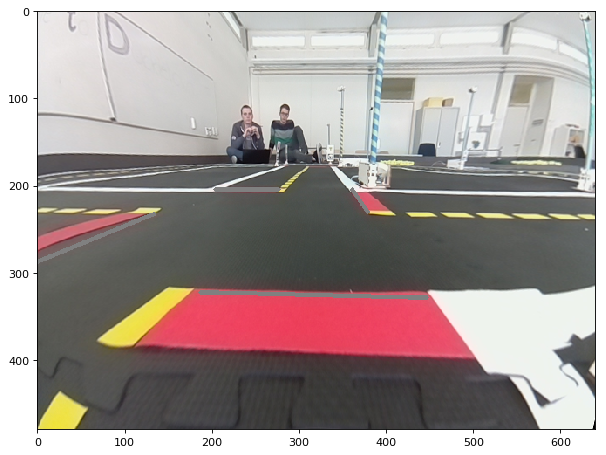

In [29]:
img = np.copy(raw[0])
rect = rectify(img)
pose = [-0.09, -.31, pi/2] # before right turn
hud = overlay(rect, pose)
bgrshow(hud)
dist_hud = dist_overlay(img, pose)
bgrshow(dist_hud)

Camera frame coordinates =  [(-0.8, 0.7, 1), (0, 0.5, 1), (0.4, 0.5, 1), (0.8, 0.5, 1)]
Distorted pixel coords = 
 [[131.20605398212956, 385.71924708653165], [314.0112503350085, 363.0063042294224], [421.26332445066015, 358.3255915443385], [507.693353563921, 345.767548706287]]
Rectified pixel coord = 
 [[154.21280993649705, 381.0461996266238, 1.0], [316.82125720212207, 334.72811796158476, 1.0], [398.1254808349346, 334.72811796158476, 1.0], [479.4297044677471, 334.72811796158476, 1.0]]


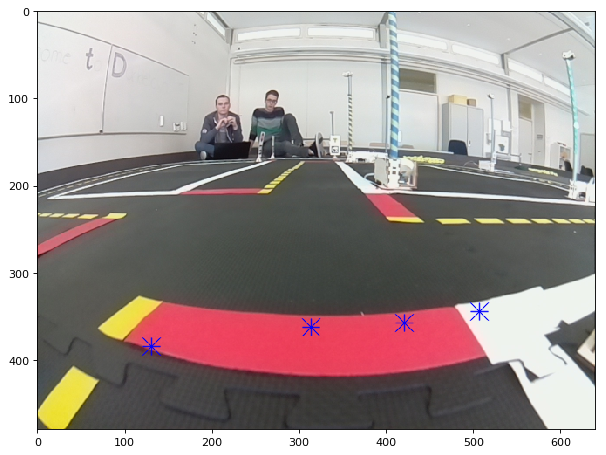

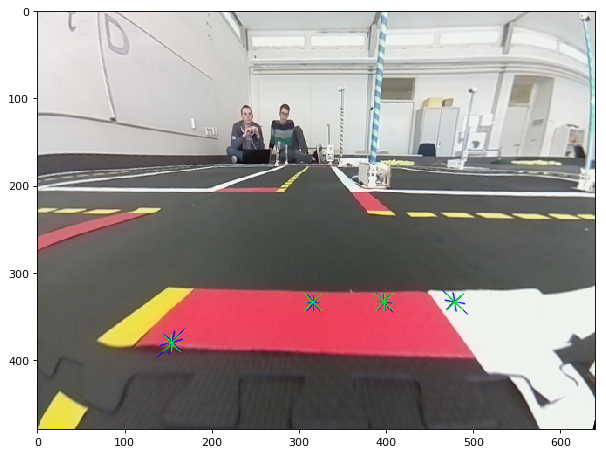

In [30]:
# SANITY CHECK:
# project points to distorted image (add markers)
# rectify marked image
# project points to rectified image (markers should be coincident)
# NOTE: this is a mathematical consistency, does not mean calibration was good

# these are coordinates of 3d points on the camera plane, wrt to the camera frame
pts = [(-0.8,0.7,1),(0,0.5,1),(0.4,0.5,1),(0.8,0.5,1)]
print('Camera frame coordinates = ', pts)

pd = cam2dist(pts)
print('Distorted pixel coords = \n', pd)

pr = cam2rect(pts)
print('Rectified pixel coord = \n', pr)

dis = np.copy(raw[0])
for i in range(len(pts)):
    cv2.drawMarker(dis, (int(pd[i][0]),int(pd[i][1])), (255,0,0), markerType=cv2.MARKER_STAR,
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)

rec = rectify(dis)

bgrshow(dis)

for i in range(len(pts)):
    cv2.drawMarker(rec, (int(pr[i][0]),int(pr[i][1])), (0,255,0), markerType=cv2.MARKER_STAR, 
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)

bgrshow(rec)

In [31]:
# NOT TESTED !
# assume img is a 1m x 1m square 
def showOnMap(img, pose):
    x = pose[0]
    y = pose[1]
    # use pose to transform the overlay
    pt0 = intersection2bird((x,y), [0, 0], 1, h)
    img = draw_segment(img, pt0, pt0, 'white')
    return img


Rectified pixle coordinates =  [(123, 374), (259, 230), (402, 264)]
Camera frame coordinates =  [(-0.95356058291613932, 0.66957473464648132, 1), (-0.28446865178003744, 0.047787325395068539, 1), (0.41906183463512842, 0.19459824146831878, 1)]
Distorted pixel coords = 
 [[105.21539820333217, 372.63797893013816], [232.12800877073084, 237.46208844361317], [431.2355278668969, 278.4126543489592]]
Rectified pixel coord = 
 [[122.99999999999997, 374.0, 1.0], [259.0, 230.0, 1.0], [402.0, 264.0, 1.0]]


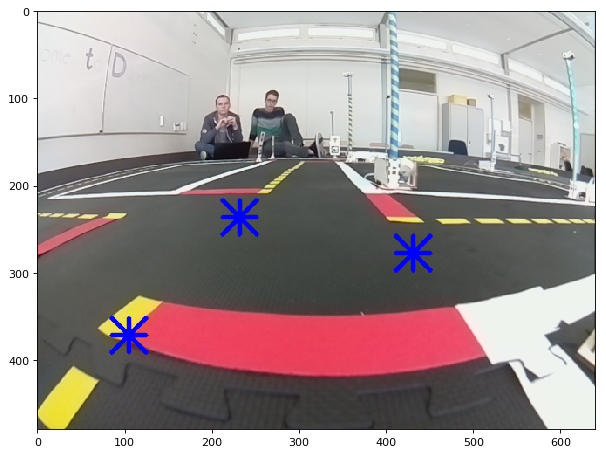

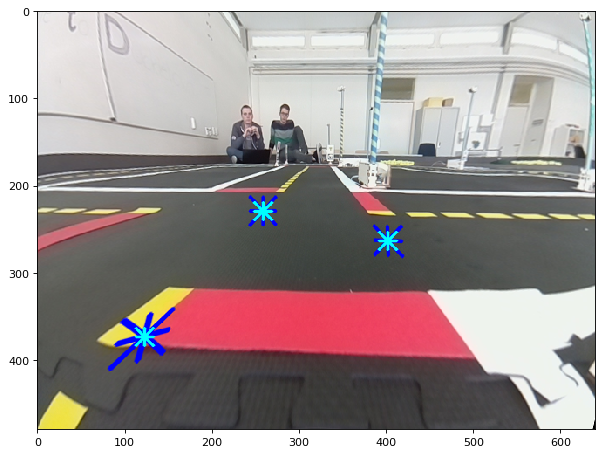

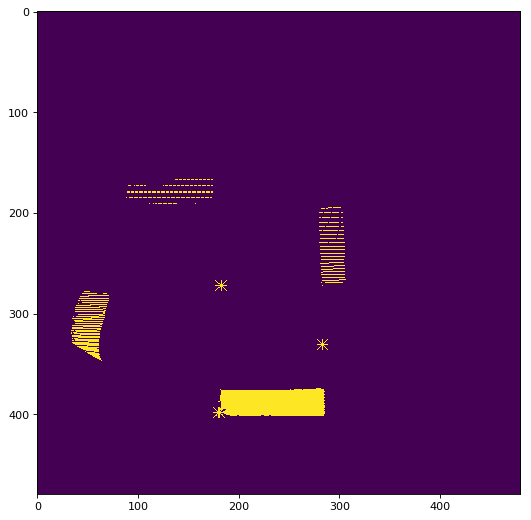

In [34]:
intp1 = [-0.21,0.12,0]
intp2 = [0,0,0]
pose = [-0.09, -.31, pi/2] # before right turn
middle = intersection2axle(intp1,pose)
target = intersection2axle(intp2,pose)

# axle coordinates, xyz in meters
# x forward, y left, z up
gnd = [(0.128+0.04, 0.003+0.12, 0), middle, target]
pr0 = []
for g in gnd:
    pr0.append(axle2rect(g)) # NOTE: you are rounding to integers but don't need to
print('Rectified pixle coordinates = ', pr0)

pts = []
for pr0i in pr0:
    pts.append(rect2cam(pr0i))
print('Camera frame coordinates = ', pts)

pd = cam2dist(pts, pcm)
print('Distorted pixel coords = \n', pd)

pr = cam2rect(pts, pcm)
print('Rectified pixel coord = \n', pr)

dis = np.copy(raw[0])
for i in range(len(pd)):
    cv2.drawMarker(dis, (int(pd[i][0]),int(pd[i][1])), (255,0,0), 
                   markerType=cv2.MARKER_STAR,
               markerSize=40, thickness=3, line_type=cv2.LINE_AA)

rec = rectify(dis)

bgrshow(dis)

for i in range(len(pr)):
    cv2.drawMarker(rec, (int(pr[i][0]),int(pr[i][1])), (0,255,0), 
                   markerType=cv2.MARKER_STAR, 
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)
for i in range(len(pr)):
    cv2.drawMarker(rec, (int(pr0[i][0]),int(pr0[i][1])), (255,255,0), 
                   markerType=cv2.MARKER_STAR, 
               markerSize=20, thickness=2, line_type=cv2.LINE_AA)

bgrshow(rec)

red = preprocess(dis)
bev = rect2bird(red,[0, 0], 1.00, 480)

gp = []
for g in gnd:
    gp.append(axle2bird(g,[0, 0], 1.00, 480))

for i in range(len(gp)):
    cv2.drawMarker(bev, (int(gp[i][0]),int(gp[i][1])), (255,255,255), 
                   markerType=cv2.MARKER_STAR, 
               markerSize=10, thickness=1, line_type=cv2.LINE_AA)

imshow(bev)

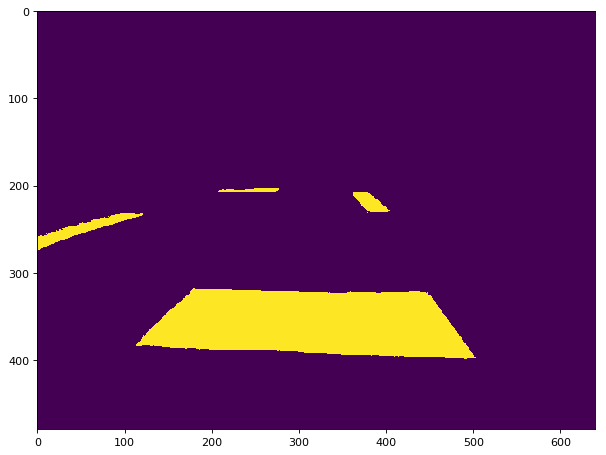

640 480


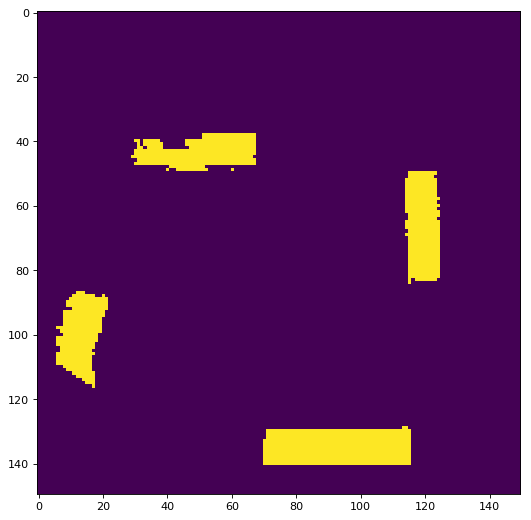

In [21]:
# SLOWER ALGO FOR GROUND PROJECTION
# not optimized for "sparse" images like filtered stop lines
# does NN interpolation though

# Each tile is 61 cm long, I want to see a tile's worth projected.
# Centered in front of the robot
x_r = np.array([0.123, 0.123+0.61])
y_r = np.array([-30.5, 30.5])

# origin: (x,y) in m coordinates of the near-left corner of the square
# side:   side in m of square on the ground 
# w:    side in pixels of the output image
def ground_project(image, origin, side, w):
    # H assumes incoming image resolution is VGA (640x480) use output_scale to fix
    # pixel at bottom center is x: 0.128 y: 0.00344677851347
    # x axis is longitudinal, y axis is to the left
    # bottom edge aligned
    x = np.linspace(origin[0]+side, origin[0], w)
    y = np.linspace(origin[1], origin[1]+side, w)
    dy,dx = np.meshgrid(y,x)
    grid = np.stack((dx,-dy) ,axis=-1)
    
    output = np.zeros((w, w))
    
    oh, ow = np.shape(image) #original width, original height
    print(ow,oh)
    for row in range(w):
        for column in range(w):
            x,y = grid[row,column]
            p = (x,y,0)
            pix = axle2rect(p)
            pix = [pix[0], pix[1]]
            pix[1] -= cutoff
            pix[1] *= output_scale
            pix[0] *= output_scale
            if pix[1] < oh and pix[1] >= 0 and pix[0] < ow and pix[0] >= 0:
                output[row,column] = image[int(pix[1]), int(pix[0])]
            else:
                output[row,column] = 0
    return output

image = preprocess(np.copy(raw[0]), rectify = True)
imshow(image)
#square = ground_project(image, [0.123, -0.305], 0.6, 100)
square = ground_project(image, [0.123, -0.45], 0.7, 150)
imshow(square)